<a href="https://colab.research.google.com/github/Tonge-Shim/1/blob/master/Assignment2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning<br> Assignment #2 Training Convolutional Neural Networks (Pytorch)

Copyright (C) This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

**For understanding of this work, please carefully look at given PPT file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.


### Some helpful tutorials and references for assignment #2:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## 0. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,#50000개
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,#10000개
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(36, 138, 3)


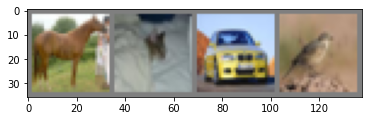

horse   cat   car  bird
torch.Size([3, 32, 32])


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[0].shape)

## 1. Training a small CNN model

#### CNN architecture in order:
* 5x5 Convolutional layer with 6 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 5x5 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 120 output units and ReLU activation
* Fully connected layer with 84 output units and ReLU activation
* Fully connected layer with 10 output units and linear activation
* You can use any padding option.

#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 4
* Training epoch: 2

In [6]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear( 400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [10]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [16]:
# Define a Loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum = 0.9)


In [17]:
# Function to train the network

def train(net, trainloader, max_epoch, crit, opt, model_path):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [18]:
PATH = './cifar_net.pth'
train(net = net, 
      trainloader = trainloader, 
      max_epoch = 2, 
      crit = criterion, 
      opt = optimizer, 
      model_path = PATH)

[1,  2000] loss: 1.746
[1,  4000] loss: 1.629
[1,  6000] loss: 1.553
[1,  8000] loss: 1.485
[1, 10000] loss: 1.455
[1, 12000] loss: 1.388
[2,  2000] loss: 1.348
[2,  4000] loss: 1.318
[2,  6000] loss: 1.290
[2,  8000] loss: 1.260
[2, 10000] loss: 1.281
[2, 12000] loss: 1.259
Finished Training
Saved Trained Model


In [19]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [20]:
print_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 55 %
